# Introduction
The objective of this notebook is to discretize HRUs in a watershed and create a weighting matrix that describes the hillslope-stream network connectivity in a catchment. This notebook is meant to replace the spatial discretization workflow (*DynatopSpatialFunctionExplicitReaches*) for the modified dynamic TOPMODEL described by Mahoney et al. (2022) *J. Hydrol*. 

To run this notebook, it is necessary to first install kernels for Python and R and install arcpy to the environment from which the notebook is run (see instructions [here](https://github.com/tyler-mahoney/modeling-streamflow-permanence/blob/main/arcpy-setup.ipynb)). Instances when switching the kernel is necessary will be denoted in a Markdown cell. 

### Step 1: Load in Necessary Libraries

In [2]:
# Import relevant libraries and output the current working directory

import arcpy
import os
import math
import pandas 
import numpy
from arcpy.sa import *
from arcpy import env
from IPython.display import display
arcpy.env.overwriteOutput = True

env.workspace = 'C:/Users/david/OneDrive/Desktop/Mahoney Research/2-Mahoney-EPA/modeling-streamflow-permanence/SpatialInputData/FallingRock.gdb' 



### Step 2: Raster Import, Fill, Flow Direction, and TWI
   
Note: This code will calculate the TWI using the D8 flow direction. It is possible to import a DINF or MFD raster here as well and use this to run the analysis, assuming that it is already in the GDB. 

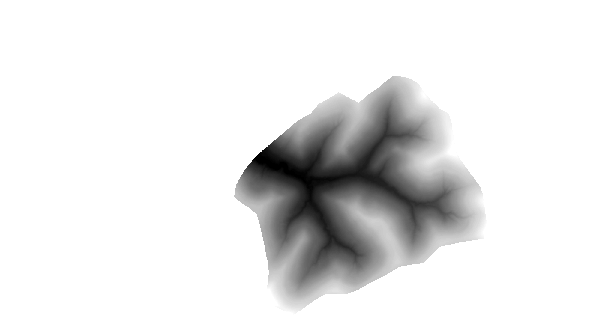

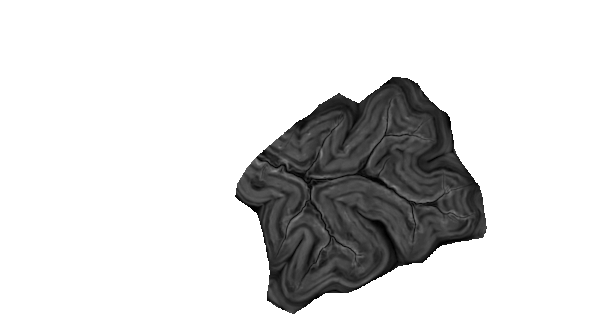

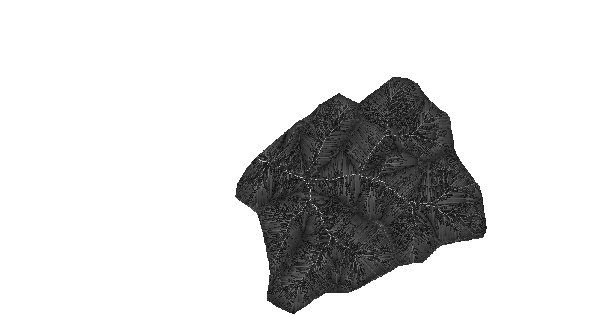

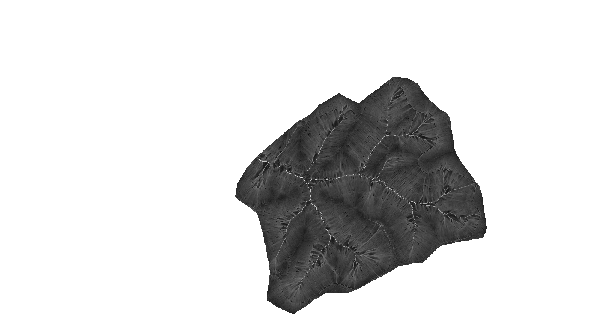

In [3]:
# Load in rasters 
FR_DEM = Raster('FR1meterDEM')
FR_HRU = Raster('FallingRockHRUs')
FR_fac_dinf = Raster('fac_dinf')

# Calculate rasters
FR_Slope = Slope(FR_DEM, "DEGREE")
FR_Slope = FR_Slope*math.pi/180
FR_fill = Fill(FR_DEM)
FR_fdr = FlowDirection(FR_fill, "Normal")
FR_fac = FlowAccumulation(FR_fdr)


# Calculate the TWI
FR_twi = Ln(((FR_fac+1))/Con(FR_Slope > 0, Tan(FR_Slope),0.0001))
FR_twi_dinf = Ln(((FR_fac_dinf+1))/Con(FR_Slope > 0, Tan(FR_Slope),0.0001))

# Display
display(FR_fill)
display(FR_Slope)
display(FR_twi)
display(FR_twi_dinf)

### Step 4: Create a HRU raster based on the TWI, soils, and other data using 

### Step 3: Create an HRU raster of the watershed using specified layers. 
Any number of layers may be input to represent HRUs. HRUs will be derived from a K-Means cluster analysis. 

### Step 3: Create a raster showing the class of downstream cells
In this step, we will return the HRU value of the cell that is immediately downstream of each cell in the watershed. 

In [13]:
# 

### Step 3b: Calculate this using the R kernel
I am doing this to see if there are any differences between the python and R code. 

In [22]:
library(sp)
library(raster)

FR.HRU <- raster('SpatialInputData/FallingRockHRUs.tif')
FR.fdr <- raster('SpatialInputData/fr_fdr')

HRU.matrix <- as.matrix(FR.HRU)
fdr.matrix <- as.matrix(FR.fdr)

fdr.downstream.matrix <- matrix(nrow=nrow(HRU.matrix),ncol=ncol(HRU.matrix))

for (i in 1:nrow(HRU.matrix)) {
  for (j in 1:ncol(HRU.matrix)) {
    if (is.na(fdr.matrix[i,j])) {
      fdr.downstream.matrix[i,j] <- NA
    } else {
      if (fdr.matrix[i,j]==1) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i,j+1]
      } else if (fdr.matrix[i,j]==2) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i+1,j+1]
      } else if (fdr.matrix[i,j]==4) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i+1,j]
      } else if (fdr.matrix[i,j]==8) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i+1,j-1]
      } else if (fdr.matrix[i,j]==16) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i,j-1]
      } else if (fdr.matrix[i,j]==32) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i-1,j-1]
      } else if (fdr.matrix[i,j]==64) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i-1,j]
      } else if (fdr.matrix[i,j]==128) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i-1,j+1]
      } else {
        fdr.downstream.matrix[i,j] <- NA
      }
    }
  }
}



### Step 4: Calculate the weighting matrix which shows the number of cells from one HRU to contribute to downstream HRUs. 
In this step, we will create a weighting matrix that outputs the proportion of flow generated in one cell that will be redistributed to downstream cells. 

This works by: 
- identifying all cells that belong to a certain HRU
- identifying all cells which belong to a downstream HRU
- identifying the cells where both of these conditions are true
- returning the number of cells where both are true 

In this regard, the output will be all cells which belong to HRU i that flow into HRU j. 

In [8]:
print('Running weighting matrix...')
start.time <- Sys.time()
for (i in 1:length(unique(FR.HRU))) {
  for (j in 1:length(unique(FR.HRU))) {
    print(unique(FR.HRU)[i])
    downstream.weighting.matrix[i,j] <- length(which((HRU.matrix==unique(FR.HRU)[i])&(fdr.downstream.matrix==unique(FR.HRU)[j])))
  }
}
end.time <- Sys.time()
end.time-start.time

options("scipen"=100, "digits"=5)

rownames(downstream.weighting.matrix) <- unique(FR.HRU)
colnames(downstream.weighting.matrix) <- unique(FR.HRU)

weighting.matrix <- downstream.weighting.matrix/rowSums(downstream.weighting.matrix)

rownames(weighting.matrix) <- unique(FR.HRU)
colnames(weighting.matrix) <- unique(FR.HRU)


[1] 8